In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta 
import os
from scipy.stats.kde import gaussian_kde
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, make_scorer, confusion_matrix, classification_report, roc_curve
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import r2_score
from collections import defaultdict


## Import Data & Clean

### Caregiver Data From System 1

In [2]:
cgs = pd.read_excel('data/caregivers_end0919.xlsx')
#cgs

### Caregiver Data From System 2

In [3]:
from src.clean_data import caregivers_system2
col_order = cgs.columns.values
cgs2 = caregivers_system2(col_order)
cgs2.head()

,Date Of Birth,Gender,Hire Date,Termination Date,Inactive,First Care Log Date,Last Care Log Date,Location,Payroll ID,State,Caregiver Tags
0,1998-07-03,Female,2018-10-10,NaT,False,2018-10-13,2018-12-31,Lafayette,22633,LA,NaN
1,1993-01-20,Female,2017-07-01,NaT,False,2017-07-10,2019-01-04,Alexandria,18937,LA,NaN
2,1999-01-03,Female,2018-09-19,NaT,False,2018-09-20,2018-12-31,Shreveport,22497,LA,NaN
3,1982-11-13,Female,2018-09-27,NaT,False,2018-09-28,2019-02-15,New Orleans,22600,LA,NaN
4,1946-08-20,Female,2018-09-28,NaT,False,2018-10-09,2019-01-03,Alexandria,22624,LA,NaN


### Combine Data Into One DataFrame

In [4]:
caregivers = pd.concat([cgs, cgs2]).drop_duplicates(subset='Payroll ID')
caregivers.head()


,Date Of Birth,Gender,Hire Date,Termination Date,Inactive,First Care Log Date,Last Care Log Date,Location,Payroll ID,State,Caregiver Tags
0,NaT,NaN,2018-10-17,2019-02-15,False,2018-12-21,2018-12-21,Shreveport,NaN,NC,CNA
1,1999-01-20,NaN,2018-10-04,2019-08-26,True,2018-10-11,2019-06-21,Lafayette,22648.0,LA,Lafayette
2,1998-05-19,NaN,2018-10-04,2018-12-17,True,NaT,NaT,Monroe,22608.0,LA,Monroe
3,1997-06-27,Female,2018-10-04,2019-03-11,True,2018-10-05,2019-03-08,Baton Rouge,21020.0,LA,Baton Rouge
4,1996-06-14,NaN,2018-10-04,2018-12-21,True,NaT,NaT,Baton Rouge,22653.0,LA,Baton Rouge


In [5]:
caregivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7738 entries, 0 to 2955
Data columns (total 11 columns):
Date Of Birth          7642 non-null datetime64[ns]
Gender                 6099 non-null object
Hire Date              7738 non-null datetime64[ns]
Termination Date       5133 non-null datetime64[ns]
Inactive               7738 non-null bool
First Care Log Date    5016 non-null datetime64[ns]
Last Care Log Date     4801 non-null datetime64[ns]
Location               7711 non-null object
Payroll ID             7737 non-null float64
State                  7719 non-null object
Caregiver Tags         3124 non-null object
dtypes: bool(1), datetime64[ns](5), float64(1), object(4)
memory usage: 672.5+ KB


## Clean Data

In [6]:
from src.clean_data import clean_cgs
caregivers = clean_cgs(caregivers)
caregivers.head()

,Gender,Hire Date,Termination Date,Inactive,First Care Log Date,Last Care Log Date,Location,Payroll ID,State,CNA,Age
1,1,2018-10-04,2019-08-26,1,2018-10-11,2019-06-21,Lafayette,22648.0,1,0,20.0
2,1,2018-10-04,2018-12-17,1,NaT,NaT,Monroe,22608.0,1,0,21.0
3,1,2018-10-04,2019-03-11,1,2018-10-05,2019-03-08,Baton Rouge,21020.0,1,0,22.0
4,1,2018-10-04,2018-12-21,1,NaT,NaT,Baton Rouge,22653.0,1,0,23.0
5,1,2018-10-04,2018-11-29,1,NaT,NaT,Monroe,22625.0,1,0,24.0


In [7]:
#caregivers.info()

## Add Features

### Payroll From Care Logs in System 1

In [8]:
from src.clean_data import df_concatenate
#df_concatenate(path)
carelogs = df_concatenate('data/carelogs/')

In [9]:
from src.clean_data import clean_carelogs
carelogs2 = clean_carelogs(carelogs)

In [10]:
from src.clean_data import clean_carelogs
carelogs2 = clean_carelogs(carelogs)
carelogs2['Official Clock In Date'] = pd.to_datetime(carelogs2['Official Clock In Date']).dt.date
carelogs2.head()

,Payroll ID,Bill Rate Name,Pay Rate Amount,Pay Total Hours,Official Clock In Date,Weekend
0,23133.0,NOW,8.0,13.0,2019-07-01,Weekday
1,116357.0,NOW PM,8.0,4.0,2019-07-01,Weekday
2,17237.0,LTPCS,8.5,8.5,2019-07-01,Weekday
3,20987.0,PACE,9.5,2.0,2019-07-01,Weekday
4,22600.0,PACE,9.5,2.0,2019-07-01,Weekday


In [11]:
#carelogs2.info()

In [12]:
carelogs2['Bill Rate Name'].unique()

array(['NOW', 'NOW PM', 'LTPCS', 'PACE', 'PCA', 'OAASCCW', 'MS PCS',
       'VA HMA', "Children's Choice", 'Evening Tuck In', 'PCA 2',
       'VA PCA', 'ROW', 'MS Respite', 'COA-Respite', 'VA Respite',
       'COA-PCA', 'EPSDT', 'COA-HMA', 'Private', 'COA-Sitter',
       'Client Specific'], dtype=object)

### Payroll From System 2

In [13]:
# payroll = df_concatenate('data/payroll3/')
# payroll = payroll.drop(columns = ['textbox19', 'textbox47', 'textbox111', 'textbox83', 'textbox86', 'textbox85', 'textbox80', 'textbox176', 'textbox173', 'textbox175', 'textbox108', 'textbox110'])
# payroll.to_csv('data/payroll2.csv')

In [14]:
payroll = pd.read_csv('data/payroll/payroll2.csv')

In [15]:
from src.clean_data import  clean_payroll
payroll2 = clean_payroll(payroll)
payroll2 = payroll2[list(carelogs2.columns.values)]
payroll2.head()

,Payroll ID,Bill Rate Name,Pay Rate Amount,Pay Total Hours,Official Clock In Date,Weekend
0,13884.0,PCA,8.00,12.0,2016-01-12,Weekday
1,14265.0,Orientation,7.25,4.0,2016-01-08,Weekday
2,14265.0,PCA,8.00,12.1,2016-01-10,Weekend
3,14190.0,Homemaker,7.50,8.0,2015-12-30,Weekday
4,14190.0,PCA,8.00,2.7,2015-12-30,Weekday


In [16]:
payroll2['Bill Rate Name'].unique()

array(['PCA', 'Orientation', 'Homemaker', 'VA HMA', 'Vets In Home',
       'Evening Tuck-In', 'VCC', 'Companion', 'Weekly OT', 'PACE BR',
       'JCOA Respite', 'PACE AM', 'VA PCA', 'JCOA HMA', 'CCOA- Respite',
       'PCA 2', 'JCOA PCA', 'Transportation', 'PACE PM', 'COAST RESP',
       'PACE ESCORT 1', 'VA Respite', 'COAST HMA', 'COAST PCA',
       'PACE HOLIDAY', 'PACE LAF', 'CCOA-PCA', 'CCOA-Sitter',
       'PACE WEEKEND', 'Staffing', 'PACE ESCORT', 'Medi HMA', 'Medi PCA',
       'NOLA OAASCCW', 'NS OAASCCW', 'NS NOW', 'BR EPSDT',
       'Laf Childrens Choice', 'BR NOW', 'NS Childrens Choice',
       'BR NOW PM', 'LC NOW', 'BR Childrens Choice', 'NS Shared PM',
       'NS Shared AM', 'NOLA NOW', 'NOLA Childrens Choice', 'Travel Time',
       'NS NOW PM', 'NS LTPCS', 'Laf LTPCS', 'BR ALZ', 'NOLA LTPCS',
       'Laf NOW', 'BR LTPCS', 'NS EPSDT', 'AL LTPCS', 'MO OAASCCW',
       'AL OAASCCW', 'MO NOW PM', 'SH LTPCS', 'SH NOW', 'SH NOW PM',
       'MO LTPCS', 'MO NOW', 'COA- PCA', 'COA

### Combine System 1 and 2 Into One DataFrame

In [17]:
pay_info = pd.concat([payroll2, carelogs2])
pay_info.head()

,Payroll ID,Bill Rate Name,Pay Rate Amount,Pay Total Hours,Official Clock In Date,Weekend
0,13884.0,PCA,8.00,12.0,2016-01-12 00:00:00,Weekday
1,14265.0,Orientation,7.25,4.0,2016-01-08 00:00:00,Weekday
2,14265.0,PCA,8.00,12.1,2016-01-10 00:00:00,Weekend
3,14190.0,Homemaker,7.50,8.0,2015-12-30 00:00:00,Weekday
4,14190.0,PCA,8.00,2.7,2015-12-30 00:00:00,Weekday


In [18]:
pay_info[pay_info['Bill Rate Name'].isnull()]

,Payroll ID,Bill Rate Name,Pay Rate Amount,Pay Total Hours,Official Clock In Date,Weekend


### Update Client Type

In [19]:
client_type = {'Private' : ['Companion', 'PCA', 'Evening Tuck-In', 'PCA 2', 'Transportation', 'Homemaker', 'Staffing', 'Evening Tuck In'], 
               'Medicaid' : ['BR EPSDT', 'BR NOW', 'BR NOW PM', 'NS Childrens Choice', 'NOLA OAASCCW', 'BR LTPCS', 'NS NOW','Laf Childrens Choice', 'Laf LTPCS', 'NS OAASCCW', 'BR OAASCCW','NOLA LTPCS', 'BR Childrens Choice', 'NS NOW PM', 'LC NOW', 'NS LTPCS', 'MO NOW', 'MO OAASCCW', 'MO LTPCS', 'MO NOW PM', 'AL LTPCS', 'AL OAASCCW', 'SH LTPCS', 'SH Childrens Choice', 'SH NOW PM', 'SH EPSDT', 'SH OAASCCW', 'AL NOW', 'SH NOW', 'Laf NOW', 'LC OAASCCW', 'NS Shared AM','NS Shared PM', 'BR ROW', 'LC LTPCS', 'LC Childrens Choice', 'MS PCS', 'NOLA NOW', 'MO ROW', 'MS Respite', 'Laf EPSDT', 'BR Personal Attendant NOW', 'NS Personal Attendant OAASCCW','NS EPSDT', 'Laf NOW PM','NO Personal Attendant NOW','NS Personal Attendant NOW', 'NO LTPCS', 'Medi HMA', 'Medi PCA', 'NOW', 'NOW PM', 'LTPCS','OAASCCW', "Children's Choice",'ROW','EPSDT', 'NO Personal Attendant OAASCCW','BR Personal Assistance', 'NO Childrens Choice', 'LC Personal Attendant NOW','Laf Personal Attendant NOW', 'NS Personal Assistant' ],
               'PACE' : ['PACE BR', 'PACE LAF', 'PACE AM', 'PACE PM', 'PACE ESCORT 1', 'PACE', 'PACE HOLIDAY', 'PACE ESCORT',  'PACE WEEKEND'],
               'VA' : ['VA HMA', 'VCC', 'VA PCA', 'VA Respite', 'Vets In Home'],
               'COA' : ['CCOA- Respite', 'CCOA-Sitter', 'JCOA Respite', 'CCOA-PCA', 'JCOA HMA', 'JCOA PCA', 'COA-Respite', 'COA- PCA', 'COA Sitter', 'COAST HMA', 'COAST RESP', 'COAST PCA', 'COA-PCA','COA-HMA', 'COA-Sitter'],
               'Other' : ['Referral Bonus', 'Home Visit', 'Incentive', 'BR ALZ', 'Orientation', 'Miscellaneous Addition', 'Travel Time']}

def client(dictionary, x):
    for k, v in dictionary.items():
        if x in v:
            return k
        
pay_info['Client Type'] = pay_info['Bill Rate Name'].apply(lambda x: client(client_type, x))
pay_info.head()


,Payroll ID,Bill Rate Name,Pay Rate Amount,Pay Total Hours,Official Clock In Date,Weekend,Client Type
0,13884.0,PCA,8.00,12.0,2016-01-12 00:00:00,Weekday,Private
1,14265.0,Orientation,7.25,4.0,2016-01-08 00:00:00,Weekday,Other
2,14265.0,PCA,8.00,12.1,2016-01-10 00:00:00,Weekend,Private
3,14190.0,Homemaker,7.50,8.0,2015-12-30 00:00:00,Weekday,Private
4,14190.0,PCA,8.00,2.7,2015-12-30 00:00:00,Weekday,Private


In [20]:
from src.clean_data import dummies
#dummies(df, col_name for dummies)
pay_info = dummies(pay_info, 'Client Type')
pay_info = dummies(pay_info, 'Weekend')
pay_info.head()

,Payroll ID,Bill Rate Name,Pay Rate Amount,Pay Total Hours,Official Clock In Date,COA,Medicaid,Other,PACE,Private,VA,Weekday,Weekend
0,13884.0,PCA,8.00,12.0,2016-01-12 00:00:00,0,0,0,0,1,0,1,0
1,14265.0,Orientation,7.25,4.0,2016-01-08 00:00:00,0,0,1,0,0,0,1,0
2,14265.0,PCA,8.00,12.1,2016-01-10 00:00:00,0,0,0,0,1,0,0,1
3,14190.0,Homemaker,7.50,8.0,2015-12-30 00:00:00,0,0,0,0,1,0,1,0
4,14190.0,PCA,8.00,2.7,2015-12-30 00:00:00,0,0,0,0,1,0,1,0


In [21]:
pay_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 482556 entries, 0 to 9838
Data columns (total 13 columns):
Payroll ID                482551 non-null float64
Bill Rate Name            482556 non-null object
Pay Rate Amount           482556 non-null float64
Pay Total Hours           482554 non-null float64
Official Clock In Date    482556 non-null object
COA                       482556 non-null uint8
Medicaid                  482556 non-null uint8
Other                     482556 non-null uint8
PACE                      482556 non-null uint8
Private                   482556 non-null uint8
VA                        482556 non-null uint8
Weekday                   482556 non-null uint8
Weekend                   482556 non-null uint8
dtypes: float64(3), object(2), uint8(8)
memory usage: 25.8+ MB


### Add Features to Previous Data Frame

In [22]:
averages = pay_info.groupby('Payroll ID', as_index = False).mean()
averages.head()

,Payroll ID,Pay Rate Amount,Pay Total Hours,COA,Medicaid,Other,PACE,Private,VA,Weekday,Weekend
0,209.0,8.000000,2.375000,0.0,0.5,0.0,0.0,0.5,0.0,1.000000,0.000000
1,299.0,9.500000,2.434783,0.0,0.0,0.0,1.0,0.0,0.0,0.791304,0.208696
2,307.0,8.947368,3.328947,0.0,0.0,0.0,0.0,1.0,0.0,0.578947,0.421053
3,450.0,8.000000,3.735000,0.0,0.0,0.0,0.0,0.5,0.5,1.000000,0.000000
4,498.0,8.000000,6.375000,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000


In [23]:
add_features = pd.merge(caregivers, averages, how = 'left', on = 'Payroll ID')
add_features.head()

,Gender,Hire Date,Termination Date,Inactive,First Care Log Date,Last Care Log Date,Location,Payroll ID,State,CNA,...,Pay Rate Amount,Pay Total Hours,COA,Medicaid,Other,PACE,Private,VA,Weekday,Weekend
0,1,2018-10-04,2019-08-26,1,2018-10-11,2019-06-21,Lafayette,22648.0,1,0,...,9.038462,6.930000,0.115385,0.000000,0.000000,0.076923,0.769231,0.038462,0.884615,0.115385
1,1,2018-10-04,2018-12-17,1,NaT,NaT,Monroe,22608.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2018-10-04,2019-03-11,1,2018-10-05,2019-03-08,Baton Rouge,21020.0,1,0,...,8.887597,2.739767,0.000000,0.271318,0.062016,0.511628,0.131783,0.023256,0.914729,0.085271
3,1,2018-10-04,2018-12-21,1,NaT,NaT,Baton Rouge,22653.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2018-10-04,2018-11-29,1,NaT,NaT,Monroe,22625.0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
add_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7710 entries, 0 to 7709
Data columns (total 21 columns):
Gender                 7710 non-null int64
Hire Date              7710 non-null datetime64[ns]
Termination Date       5123 non-null datetime64[ns]
Inactive               7710 non-null int64
First Care Log Date    5004 non-null datetime64[ns]
Last Care Log Date     4789 non-null datetime64[ns]
Location               7710 non-null object
Payroll ID             7710 non-null float64
State                  7710 non-null int64
CNA                    7710 non-null int64
Age                    7710 non-null float64
Pay Rate Amount        5229 non-null float64
Pay Total Hours        5229 non-null float64
COA                    5229 non-null float64
Medicaid               5229 non-null float64
Other                  5229 non-null float64
PACE                   5229 non-null float64
Private                5229 non-null float64
VA                     5229 non-null float64
Weekday            

### Impute NaNs

#### Pay Rates

In [25]:
pay_rates = {'Alexandria': 7.50, 'Baton Rouge': 8, 'Lafayette': 8, 'Monroe' : 7.50, 
             'Lake Charles':8, 'New Orleans':8, 'Shreveport' : 7.50, 'Jackson': 9,
            'Northshore' : 8, 'Yazoo City': 9}

add_features['Pay Rate Amount'] = add_features['Pay Rate Amount'].fillna(add_features['Location'].map(pay_rates))

#add_features.info()


#### Get Dummies Columns

In [26]:
cols = ['Pay Total Hours', 'COA', 'Medicaid', 'Other', 'PACE', 'Private', 'VA', 'Weekday', 'Weekend']
def fillna(df, cols):
    for i in cols:
        df[i] = df[i].fillna(0)
    return df

add_features = fillna(add_features,cols)
#add_features.info()        

## EDA

### Count of Active vs Inactive Users

In [27]:
active_count = add_features[add_features['Inactive'] == 0].count()['Payroll ID']
inactive_count = add_features[add_features['Inactive'] == 1].count()['Payroll ID']

print('Active Count = ', active_count)
print('Inactive Count = ', inactive_count)

Active Count =  528
Inactive Count =  7182


In [28]:
## Because the amounts are so skewed, changing my project to classify based on length of employment. 

### Find Out Cut Off Point For Classification

In [29]:
def churn(df):
    '''
    Find empty termination dates and impute
    Create new column labelled employment_length
    '''
    
    ## Find if there is anyone whose last care log date is greater than their termination date and replace
    df['Termination Date'] = np.where(df['Termination Date'] < df['Last Care Log Date'], 
                                           df['Last Care Log Date'], df['Termination Date'])
    
    ## Create new column with employment length. 
    df['Employment Length'] = ((df['Termination Date'] - df['Hire Date']).dt.days)

    df['Employment Length'] = df['Employment Length'].fillna((df['Last Care Log Date'] 
                                                          - df['Hire Date']).dt.days)
    
    ## Drop null values for employment length
    df = df.dropna(subset=['Employment Length'])

    
    return df

caregivers = churn(add_features)
caregivers.head()

,Gender,Hire Date,Termination Date,Inactive,First Care Log Date,Last Care Log Date,Location,Payroll ID,State,CNA,...,Pay Total Hours,COA,Medicaid,Other,PACE,Private,VA,Weekday,Weekend,Employment Length
0,1,2018-10-04,2019-08-26,1,2018-10-11,2019-06-21,Lafayette,22648.0,1,0,...,6.930000,0.115385,0.000000,0.000000,0.076923,0.769231,0.038462,0.884615,0.115385,326.0
1,1,2018-10-04,2018-12-17,1,NaT,NaT,Monroe,22608.0,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.0
2,1,2018-10-04,2019-03-11,1,2018-10-05,2019-03-08,Baton Rouge,21020.0,1,0,...,2.739767,0.000000,0.271318,0.062016,0.511628,0.131783,0.023256,0.914729,0.085271,158.0
3,1,2018-10-04,2018-12-21,1,NaT,NaT,Baton Rouge,22653.0,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,78.0
4,1,2018-10-04,2018-11-29,1,NaT,NaT,Monroe,22625.0,1,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,56.0


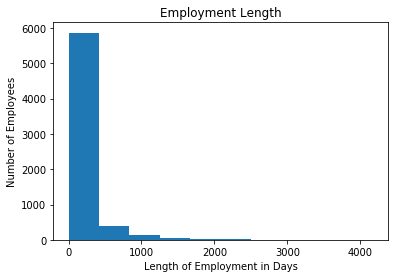

In [30]:
fig, ax = plt.subplots()
ax.hist(caregivers['Employment Length'])
ax.set_title('Employment Length')
ax.set_ylabel('Number of Employees')
ax.set_xlabel('Length of Employment in Days');

In [31]:
#Graph above looks very skewed, check amounts for each.
caregivers1= caregivers
for i in range(0,4100,100):
    x = caregivers1[caregivers1['Employment Length']<i].count()['Payroll ID']
    caregivers1 = caregivers1[caregivers1['Employment Length']>=i]
    print('by {} days {} employees left'.format(i, x))

by 0 days 0 employees left
by 100 days 3910 employees left
by 200 days 1145 employees left
by 300 days 501 employees left
by 400 days 283 employees left
by 500 days 147 employees left
by 600 days 121 employees left
by 700 days 77 employees left
by 800 days 56 employees left
by 900 days 83 employees left
by 1000 days 20 employees left
by 1100 days 17 employees left
by 1200 days 19 employees left
by 1300 days 20 employees left
by 1400 days 17 employees left
by 1500 days 10 employees left
by 1600 days 8 employees left
by 1700 days 11 employees left
by 1800 days 3 employees left
by 1900 days 1 employees left
by 2000 days 4 employees left
by 2100 days 2 employees left
by 2200 days 2 employees left
by 2300 days 3 employees left
by 2400 days 2 employees left
by 2500 days 2 employees left
by 2600 days 1 employees left
by 2700 days 1 employees left
by 2800 days 1 employees left
by 2900 days 0 employees left
by 3000 days 1 employees left
by 3100 days 1 employees left
by 3200 days 4 employees lef

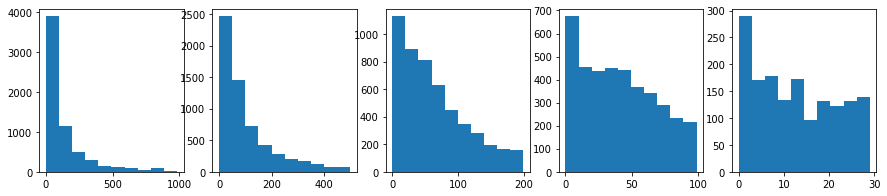

In [32]:
x_1000 = caregivers[caregivers['Employment Length']<1000]
x_500 = caregivers[caregivers['Employment Length']<500]
x_200 = caregivers[caregivers['Employment Length']<200]
x_100 = caregivers[caregivers['Employment Length']<100]
x_30= caregivers[caregivers['Employment Length']<30]

fig, ax = plt.subplots(1,5, figsize = (15,3))
ax[0].hist(x_1000['Employment Length'])
ax[1].hist(x_500['Employment Length'])
ax[2].hist(x_200['Employment Length'])
ax[3].hist(x_100['Employment Length'])
ax[4].hist(x_30['Employment Length']);

Text(0.5, 0, 'Days of Employment')

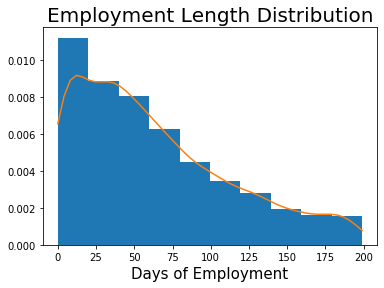

In [33]:
x_200 = caregivers[caregivers['Employment Length']<200]
x = np.linspace(np.min(x_200['Employment Length']), np.max(x_200['Employment Length']))
kde = gaussian_kde(x_200['Employment Length'])
fig, ax = plt.subplots()
ax.hist(x_200['Employment Length'], density=True)
ax.plot(x, kde(x))
ax.set_title('Employment Length Distribution', fontsize=20)
ax.set_xlabel('Days of Employment', fontsize=15)




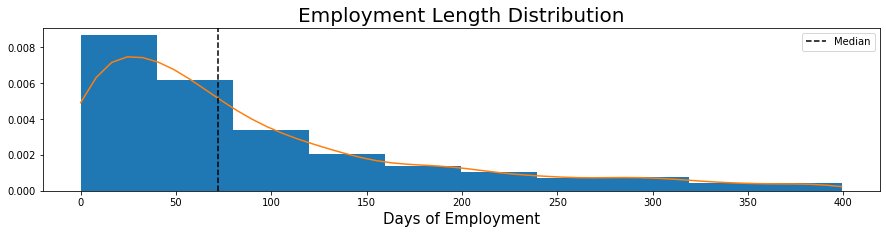

In [34]:
x_200 = caregivers[caregivers['Employment Length']<400]
x = np.linspace(np.min(x_200['Employment Length']), np.max(x_200['Employment Length']))
kde = gaussian_kde(x_200['Employment Length'])
fig, ax = plt.subplots(figsize=(15,3))
ax.hist(x_200['Employment Length'], density=True)
ax.plot(x, kde(x))
ax.set_title('Employment Length Distribution', fontsize=20)
ax.set_xlabel('Days of Employment', fontsize=15)
ax.axvline(round(caregivers['Employment Length'].median(),2), color='black',linestyle='--', label='Median')
ax.legend()


In [35]:
#Most are under 100, check amounts for each range
caregivers1 = caregivers
for i in range(0, 100,10):
    x = caregivers1[caregivers1['Employment Length']<i].count()['Payroll ID']
    caregivers1 = caregivers1[caregivers1['Employment Length']>=i]
    print('by {} days {} employees left'.format(i, x))

by 0 days 0 employees left
by 10 days 674 employees left
by 20 days 454 employees left
by 30 days 439 employees left
by 40 days 451 employees left
by 50 days 443 employees left
by 60 days 367 employees left
by 70 days 344 employees left
by 80 days 289 employees left
by 90 days 235 employees left


In [36]:
# Cumulative amounts for each range
caregivers1 = caregivers
for i in range(0, 100,10):
    x = caregivers1[caregivers1['Employment Length']<i].count()['Payroll ID']
    print('by {} days {} employees left'.format(i, x))

by 0 days 0 employees left
by 10 days 674 employees left
by 20 days 1128 employees left
by 30 days 1567 employees left
by 40 days 2018 employees left
by 50 days 2461 employees left
by 60 days 2828 employees left
by 70 days 3172 employees left
by 80 days 3461 employees left
by 90 days 3696 employees left


In [37]:
all_median = round(caregivers['Employment Length'].median(),2)
all_mean = round(caregivers['Employment Length'].mean(),2)
active_mean = round(caregivers[caregivers['Inactive']==0].mean()['Employment Length'],2)
active_median = round(caregivers[caregivers['Inactive']==0].median()['Employment Length'],2)
inactive_mean = round(caregivers[caregivers['Inactive']==1].mean()['Employment Length'],2)
inactive_median = round(caregivers[caregivers['Inactive']==1].median()['Employment Length'],2)

print('Active Mean of Employment Length = {} days'.format(active_mean))
print('Active Median of Employment Length = {} days '.format(active_median))
print('Inactive Mean of Employment Length = {} days'.format(inactive_mean))
print('Inactive Median of Employment Length = {} days'.format(inactive_median))
print('Total Mean of Employment Length = {} days'.format(all_mean))
print('Total Median of Employment Length = {} days'.format(all_median))

Active Mean of Employment Length = 392.28 days
Active Median of Employment Length = 231.5 days 
Inactive Mean of Employment Length = 145.62 days
Inactive Median of Employment Length = 67.5 days
Total Mean of Employment Length = 165.11 days
Total Median of Employment Length = 72.0 days


In [38]:
## Will use total median as cut off for classifier: 72 days.

In [39]:
caregivers['Churn Status'] = np.where(caregivers['Employment Length'] >= all_median, 0, 1)

/home/lea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### How many days after first shift is best to use for the feature?

In [40]:
from src.clean_data import first_shift
#first_shift(df, n_days)

In [41]:
caregivers = first_shift(caregivers, 7)
caregivers = first_shift(caregivers, 14)
caregivers.columns

/home/lea/Galvanize/capstone2/employee_retention/src/clean_data.py:172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['first_shift_within_{}_days'.format(n_days)] = np.where(df['First Care Log Date'] - df['Hire Date'] <= timedelta(days=n_days), 1, 0)


Index(['Gender', 'Hire Date', 'Termination Date', 'Inactive',
       'First Care Log Date', 'Last Care Log Date', 'Location', 'Payroll ID',
       'State', 'CNA', 'Age', 'Pay Rate Amount', 'Pay Total Hours', 'COA',
       'Medicaid', 'Other', 'PACE', 'Private', 'VA', 'Weekday', 'Weekend',
       'Employment Length', 'Churn Status', 'first_shift_within_7_days',
       'first_shift_within_14_days'],
      dtype='object')

In [42]:
active_7 = caregivers.groupby(caregivers['first_shift_within_7_days'] == 1).count()['Inactive']
active_14 = caregivers.groupby(caregivers['first_shift_within_14_days'] == 1).count()['Inactive']

seven = active_7[True]/active_7.sum()
fourteen = active_14[True]/active_14.sum()


print('7 days active percentage = {}'.format(round(seven,2)))
print('14 days active percentage = {}'.format(round(fourteen,2)))


7 days active percentage = 0.58
14 days active percentage = 0.67


In [43]:
## Not much of a difference, but since we are going with the median of 72 days, we will use 7 days

In [44]:
## Drop Termination Date, First Care Log Date, Last Care Log Date, and first_shift_within_14_days
caregivers = caregivers.drop(columns=['Termination Date', 'First Care Log Date', 
                                      'Last Care Log Date', 'first_shift_within_7_days'])

#### Graphs with features vs active/inactive employees

In [45]:
active = caregivers[caregivers['Employment Length'] >= np.median(caregivers['Employment Length'])]
inactive = caregivers[caregivers['Employment Length'] < np.median(caregivers['Employment Length'])]
print('Active Count = ',active.count()['Payroll ID'])
print('Inactive Count = ',inactive.count()['Payroll ID'])

Active Count =  3249
Inactive Count =  3229


In [46]:
print('Current Churn Percentage =', 3249/(3249+3229))

Current Churn Percentage = 0.5015436863229392


In [47]:
#caregivers.info()

/home/lea/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


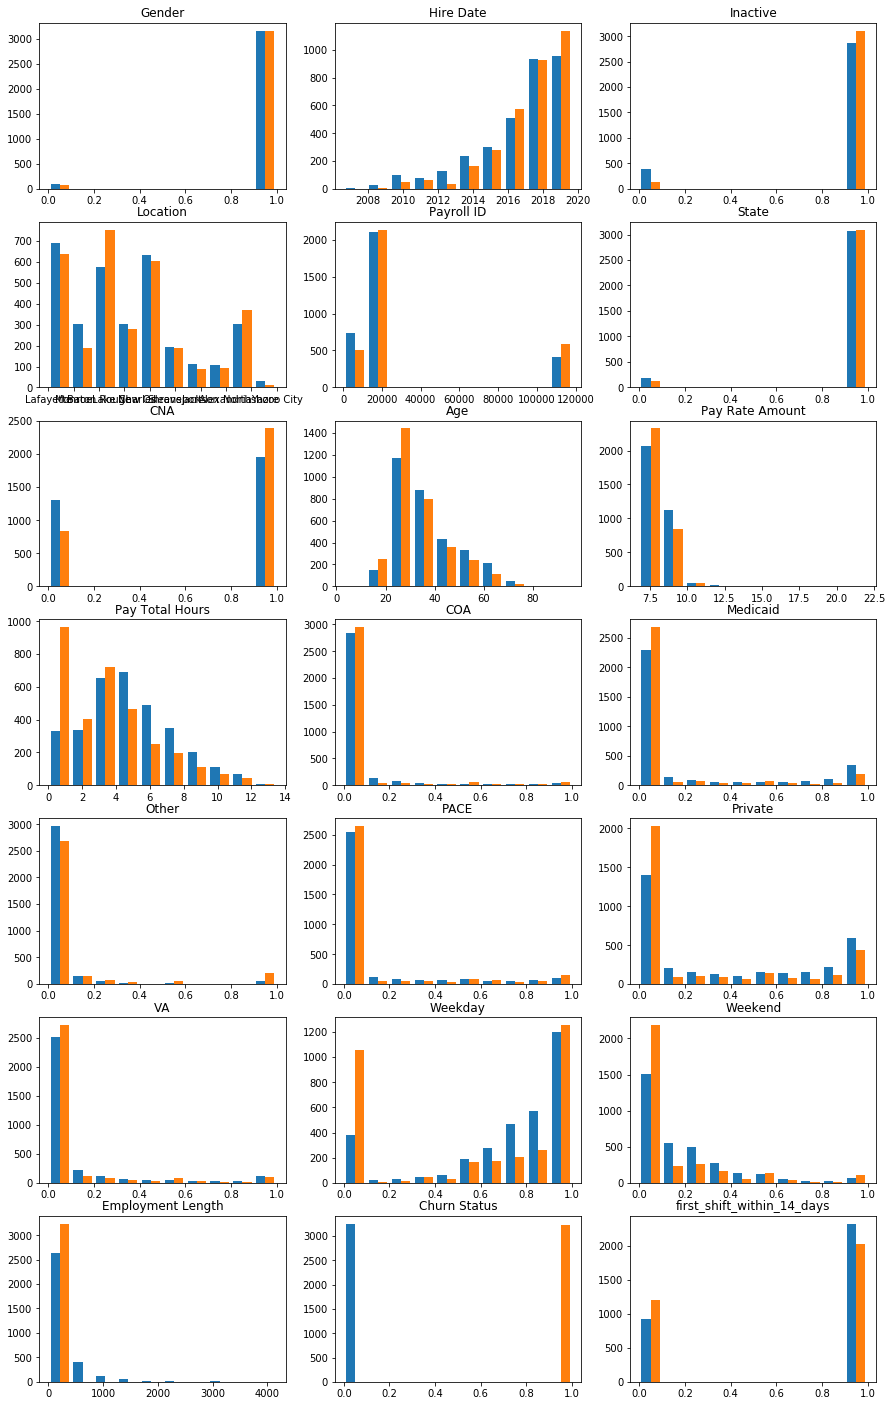

In [48]:
def distributions(plot_size, fig_size, df1, df2, columns):
    fig, axs = plt.subplots(plot_size[0], plot_size[1], figsize=fig_size)
    keys = []
    for i in range(plot_size[0]):
        for j in range(plot_size[1]):
            keys.append((i,j))

    for idx, column in zip(keys,columns):
        cols = df1[column]
        cols2 = df2[column]
        axs[idx[0]][idx[1]].set_title(column)
        axs[idx[0]][idx[1]].hist([cols, cols2])

cols = [i for i in list(active.columns)]
distributions((7, 3), (15,25), active, inactive, cols)

/home/lea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


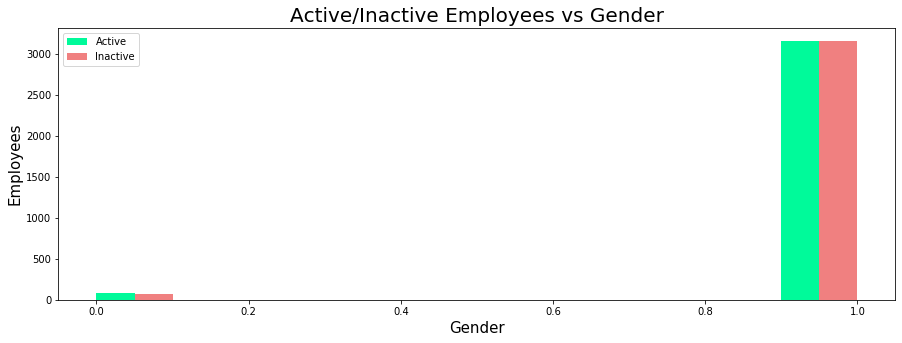

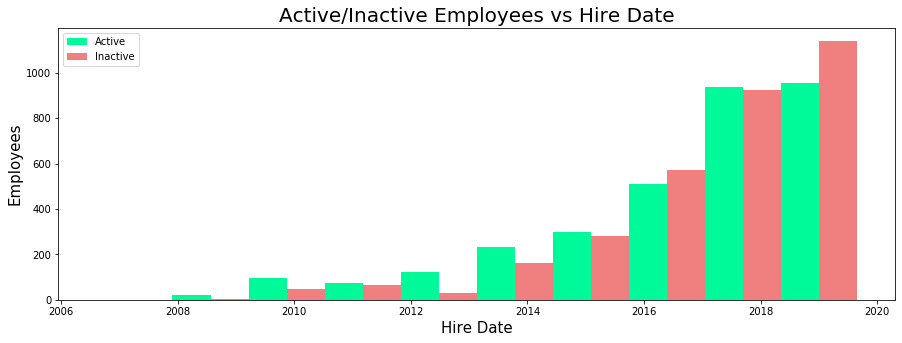

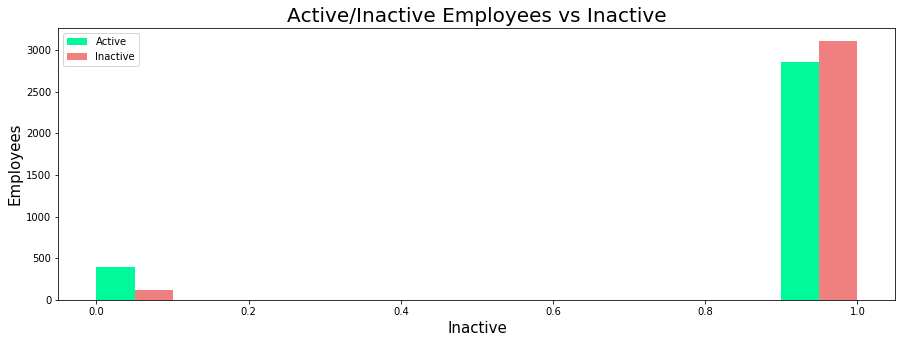

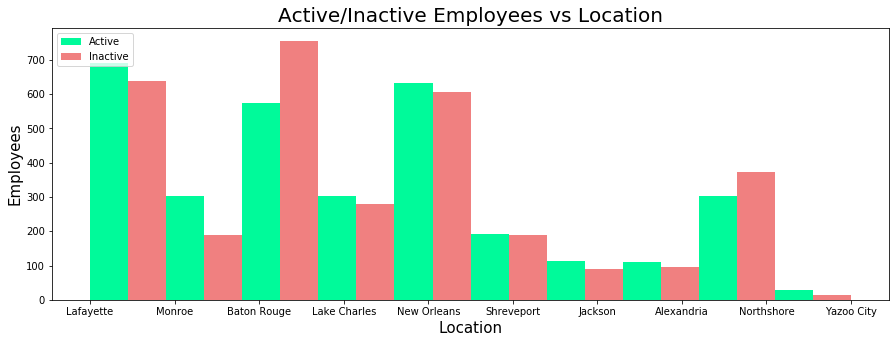

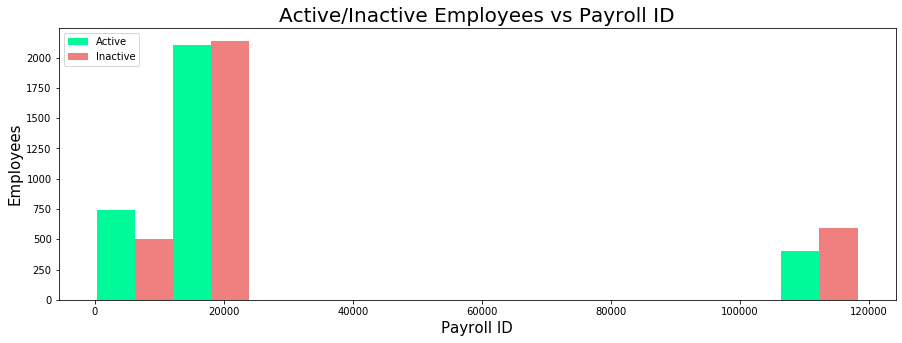

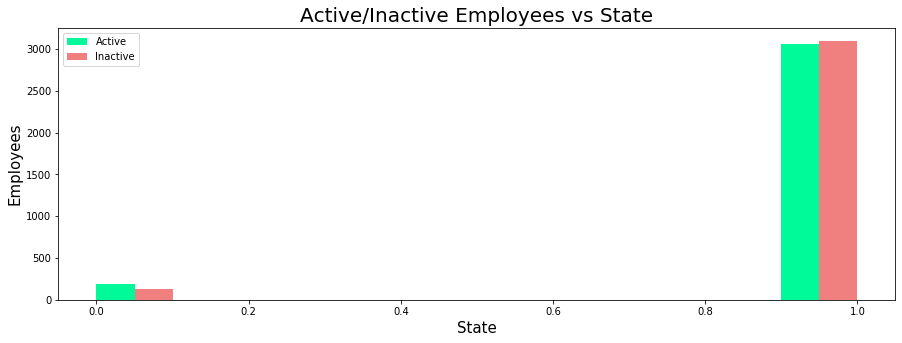

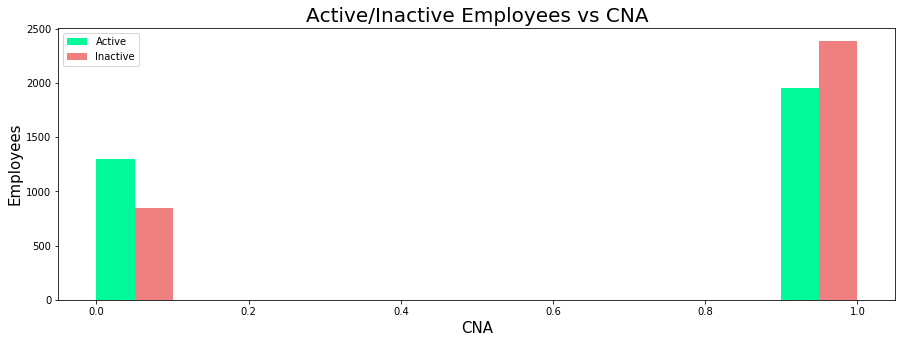

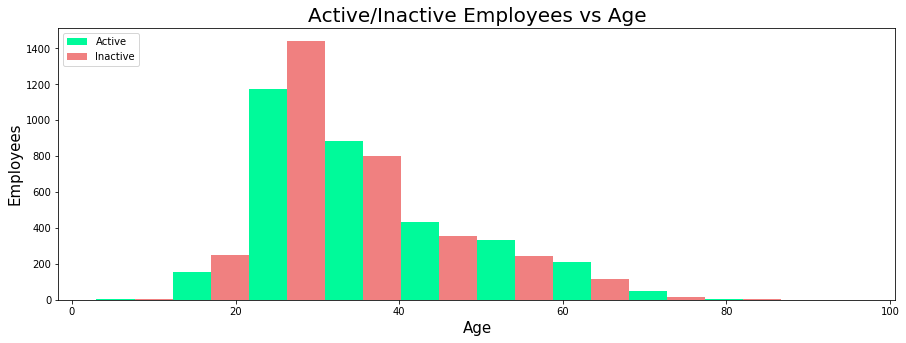

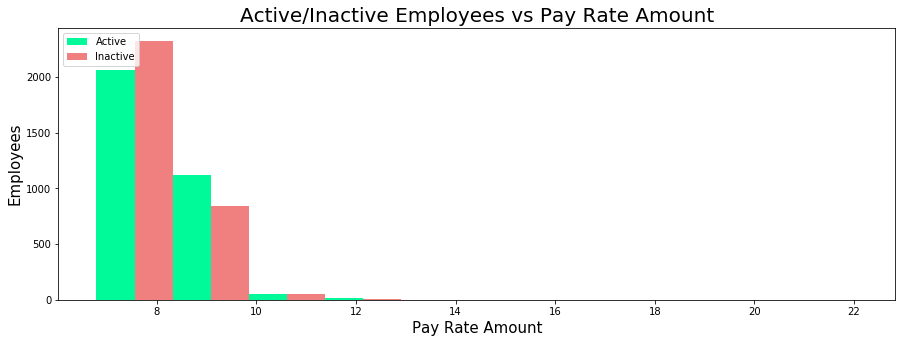

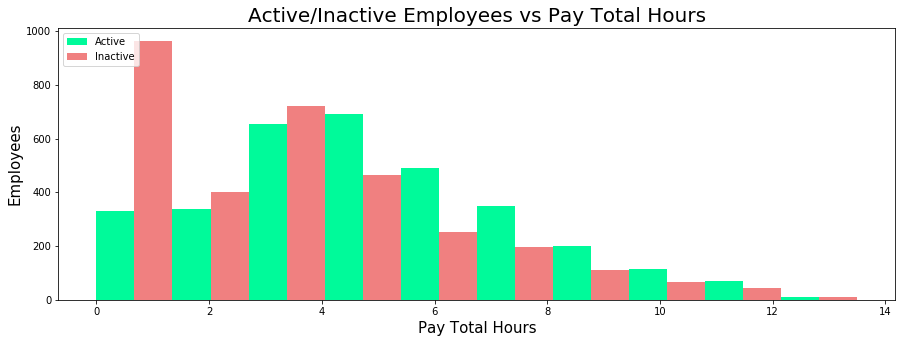

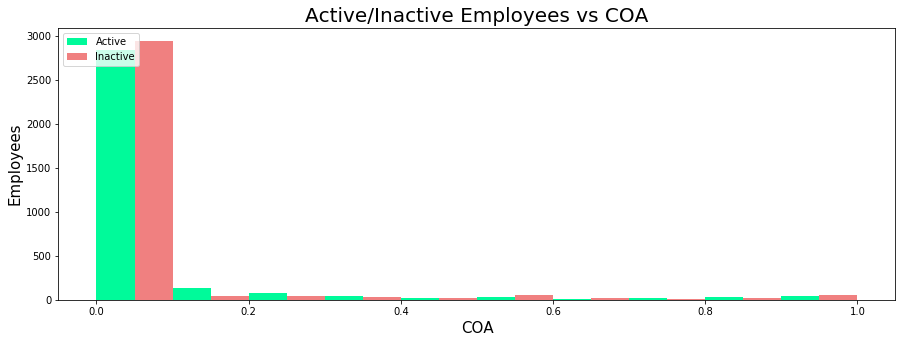

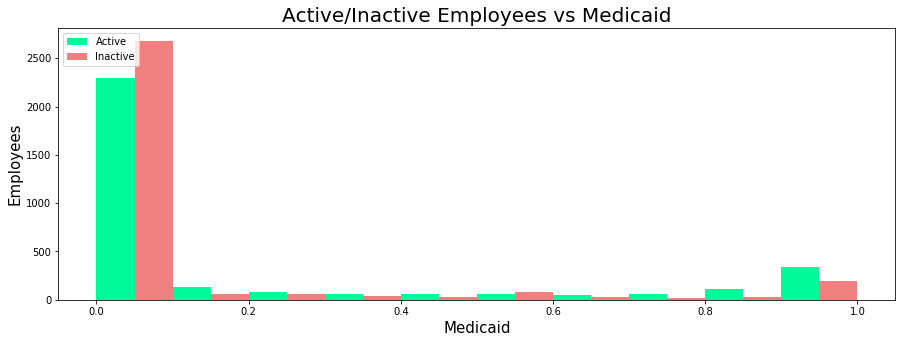

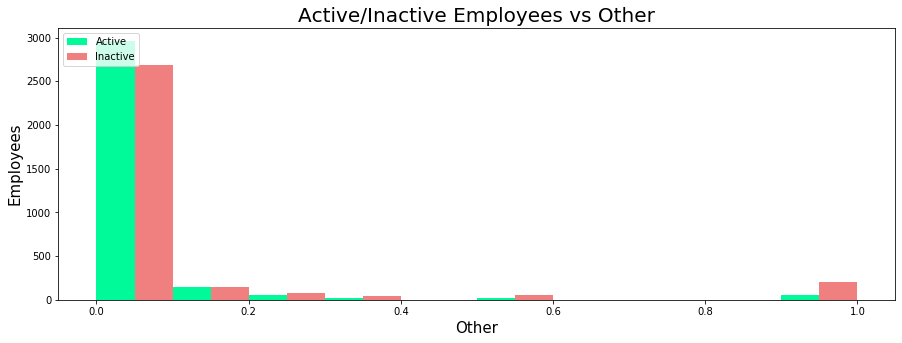

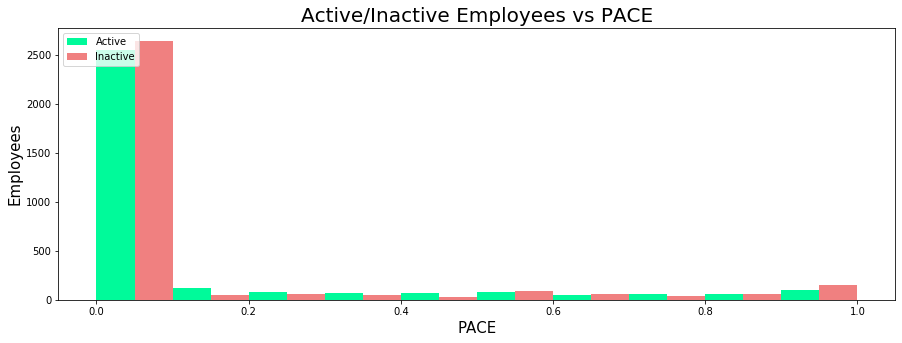

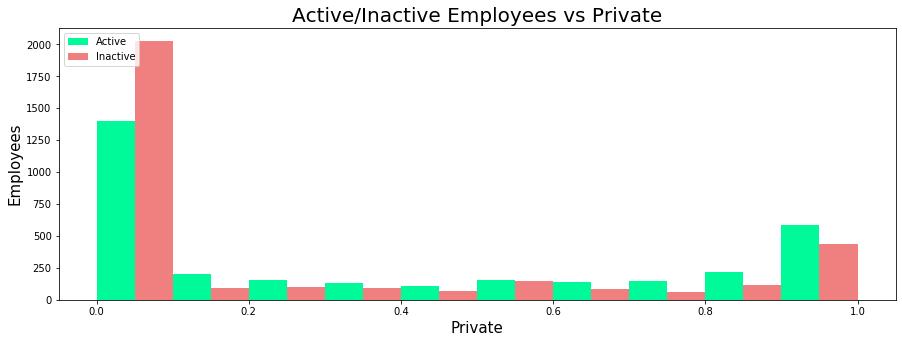

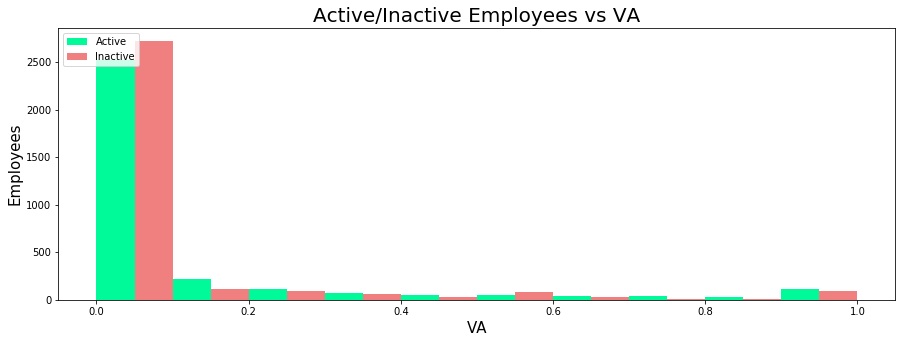

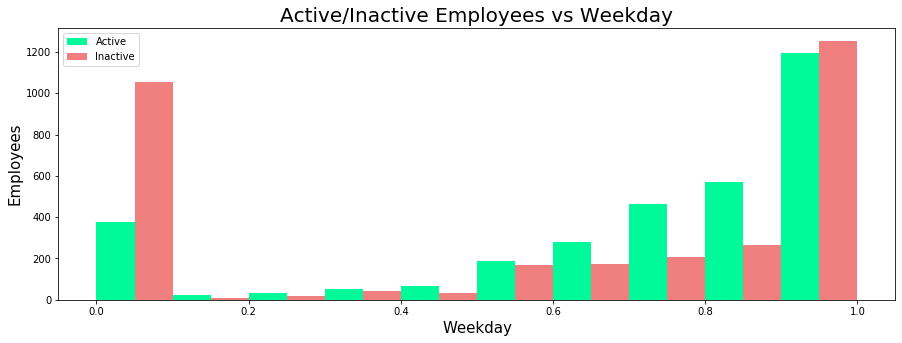

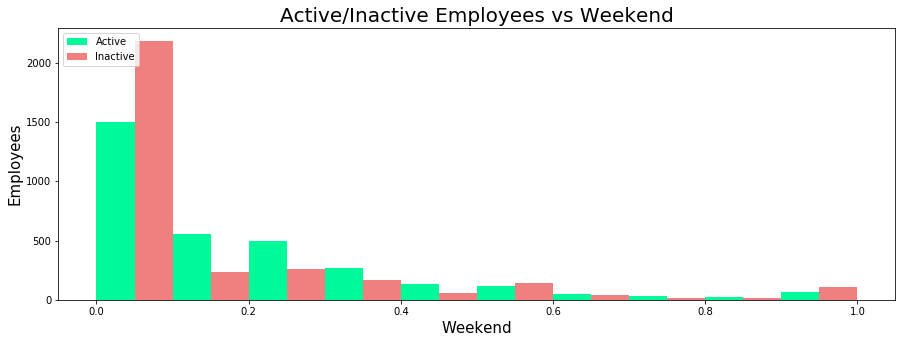

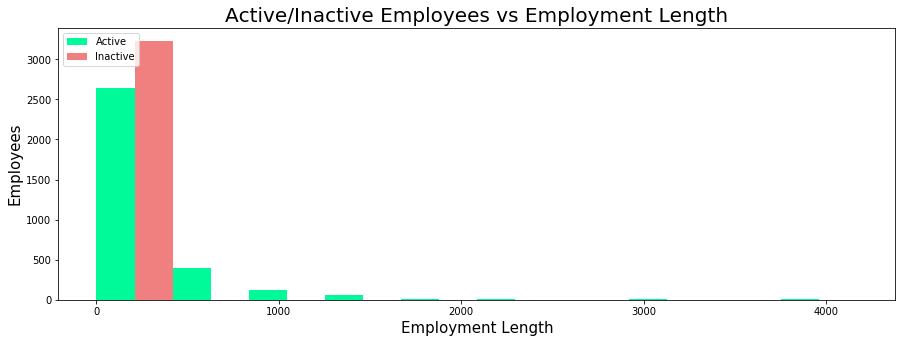

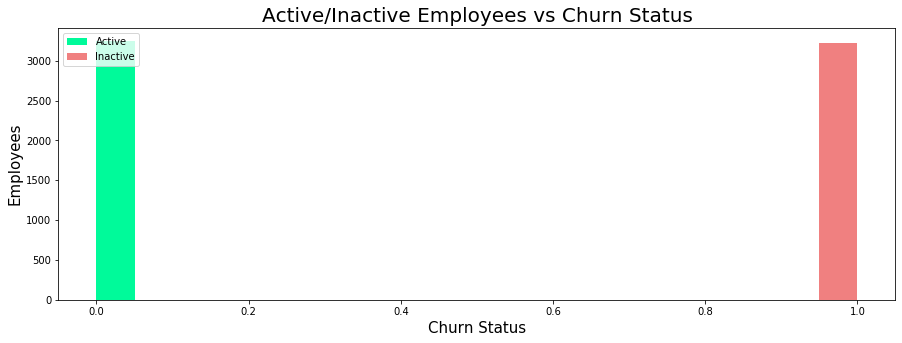

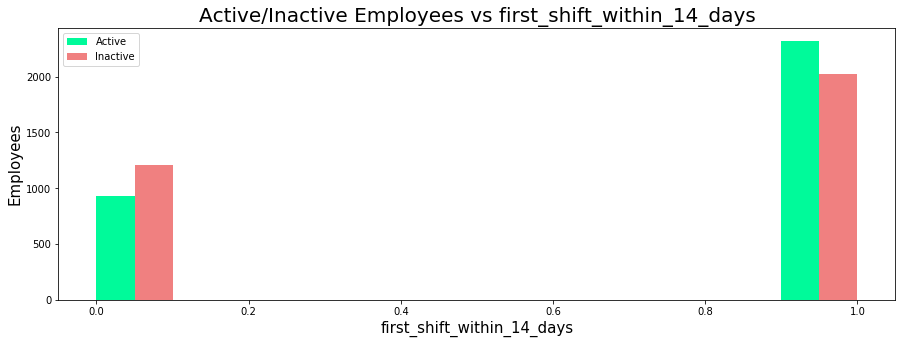

In [49]:
def active_inactive_graph(col_name):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.hist([active[col_name], 
             inactive[col_name]], 
            label=['Active', 'Inactive'], 
           color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
    ax.legend(loc='upper left');
    ax.set_xlabel(col_name,fontsize=15)
    ax.set_ylabel('Employees', fontsize=15)
    ax.set_title('Active/Inactive Employees vs '+ col_name, fontsize=20);
    
# col_name = ['Gender', 'Location', 'CNA', 'Age',
#        'first_shift_within_7_days', 'first_shift_within_14_days',
#        'first_shift_within_30_days']

col_name = [i for i in caregivers.columns]

for i in col_name:
    active_inactive_graph(i)

## Get Dummies

In [50]:
caregivers = dummies(caregivers, 'Location')
caregivers.columns

Index(['Gender', 'Hire Date', 'Inactive', 'Payroll ID', 'State', 'CNA', 'Age',
       'Pay Rate Amount', 'Pay Total Hours', 'COA', 'Medicaid', 'Other',
       'PACE', 'Private', 'VA', 'Weekday', 'Weekend', 'Employment Length',
       'Churn Status', 'first_shift_within_14_days', 'Alexandria',
       'Baton Rouge', 'Jackson', 'Lafayette', 'Lake Charles', 'Monroe',
       'New Orleans', 'Northshore', 'Shreveport', 'Yazoo City'],
      dtype='object')

#### Drop unwanted columns

In [51]:
caregivers= caregivers.drop(columns = ['Hire Date', 'Payroll ID'])

In [52]:
caregivers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6478 entries, 0 to 7709
Data columns (total 28 columns):
Gender                        6478 non-null int64
Inactive                      6478 non-null int64
State                         6478 non-null int64
CNA                           6478 non-null int64
Age                           6478 non-null float64
Pay Rate Amount               6478 non-null float64
Pay Total Hours               6478 non-null float64
COA                           6478 non-null float64
Medicaid                      6478 non-null float64
Other                         6478 non-null float64
PACE                          6478 non-null float64
Private                       6478 non-null float64
VA                            6478 non-null float64
Weekday                       6478 non-null float64
Weekend                       6478 non-null float64
Employment Length             6478 non-null float64
Churn Status                  6478 non-null int64
first_shift_within_

## Models

In [53]:
from src.models import score_matrix, score, cross_val, gridsearch, model_score

In [54]:
X = caregivers.drop(columns = ['Inactive', 'Churn Status', 'Gender', 'State', 'Other', 'Employment Length', 'first_shift_within_14_days'])
y = caregivers['Churn Status']
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [55]:
X.columns

Index(['CNA', 'Age', 'Pay Rate Amount', 'Pay Total Hours', 'COA', 'Medicaid',
       'PACE', 'Private', 'VA', 'Weekday', 'Weekend', 'Alexandria',
       'Baton Rouge', 'Jackson', 'Lafayette', 'Lake Charles', 'Monroe',
       'New Orleans', 'Northshore', 'Shreveport', 'Yazoo City'],
      dtype='object')

### Logistic Regression

In [56]:
log_reg = LogisticRegression(solver = 'liblinear')
cross_val(log_reg, X_train, y_train, k=10)

('Cross Validation Score', 0.6556276780789954)

In [57]:
model_score(log_reg, X_train, y_train, X_test, y_test)

Score Matrix: 
Model: LogisticRegression
precision = 67.04%
recall = 59.93%
accuracy = 65.62%, score = 65.62%
None 

Classification Report: 

              precision    recall  f1-score   support

           0       0.64      0.71      0.68       819
           1       0.67      0.60      0.63       801

    accuracy                           0.66      1620
   macro avg       0.66      0.66      0.65      1620
weighted avg       0.66      0.66      0.66      1620



In [58]:
#LogisticRegression().get_params()

In [59]:
parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
gridsearch(log_reg, parameters, X_train, y_train, X_test, y_test)

log loss = 0.6216715947702552
accuracy = 0.6555555555555556
Best Estimator: 
  LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Best Params: 
 {'C': 10}


In [60]:
log_grid = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
cross_val(log_grid, X_train, y_train, k=10)

('Cross Validation Score', 0.6541725001060625)

In [61]:
model_score(log_grid, X_train, y_train, X_test, y_test)

Score Matrix: 
Model: LogisticRegression
precision = 66.85%
recall = 60.17%
accuracy = 65.56%, score = 65.56%
None 

Classification Report: 

              precision    recall  f1-score   support

           0       0.65      0.71      0.68       819
           1       0.67      0.60      0.63       801

    accuracy                           0.66      1620
   macro avg       0.66      0.65      0.65      1620
weighted avg       0.66      0.66      0.65      1620



### Gradient Boosting

In [62]:
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=.74, max_features=4, max_depth=2, random_state=1)
cross_val(gb, X_train, y_train, k=10)

('Cross Validation Score', 0.7046103262483561)

In [63]:
model_score(gb, X_train, y_train, X_test, y_test)

Score Matrix: 
Model: GradientBoostingClassifier
precision = 69.22%
recall = 73.28%
accuracy = 70.68%, score = 70.68%
None 

Classification Report: 

              precision    recall  f1-score   support

           0       0.72      0.68      0.70       819
           1       0.69      0.73      0.71       801

    accuracy                           0.71      1620
   macro avg       0.71      0.71      0.71      1620
weighted avg       0.71      0.71      0.71      1620



In [64]:
#GradientBoostingClassifier().get_params()

In [65]:
parameters = {'max_depth' : np.arange(1, 12, 1),
             'min_samples_leaf' : np.arange(5,95,10)}
gridsearch(gb, parameters, X_train, y_train, X_test, y_test)

log loss = 0.5604635594833804
accuracy = 0.721604938271605
Best Estimator: 
  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.74, loss='deviance', max_depth=1,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=85, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
Best Params: 
 {'max_depth': 1, 'min_samples_leaf': 85}


In [ ]:
parameters = {'max_depth' : np.arange(1, 12, 1),
             'min_samples_leaf' : np.arange(5,95,10),
             'learning_rate': np.arange(.01,1,.1)}
gridsearch(gb, parameters, X_train, y_train, X_test, y_test)


In [66]:
gb1 = GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=65, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

cross_val(gb1, X_train, y_train, k=10)

('Cross Validation Score', 0.7169619447626321)

In [67]:
model_score(gb1, X_train, y_train, X_test, y_test)

Score Matrix: 
Model: GradientBoostingClassifier
precision = 70.89%
recall = 72.66%
accuracy = 71.73%, score = 71.73%
None 

Classification Report: 

              precision    recall  f1-score   support

           0       0.73      0.71      0.72       819
           1       0.71      0.73      0.72       801

    accuracy                           0.72      1620
   macro avg       0.72      0.72      0.72      1620
weighted avg       0.72      0.72      0.72      1620



In [68]:
gb2 =   GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.74, loss='deviance', max_depth=1,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=85, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=300,
                           n_iter_no_change=None, presort='auto',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

cross_val(gb2, X_train, y_train, k=10)

('Cross Validation Score', 0.7188099783632429)

In [69]:
model_score(gb2, X_train, y_train, X_test, y_test)

Score Matrix: 
Model: GradientBoostingClassifier
precision = 70.83%
recall = 74.28%
accuracy = 72.16%, score = 72.16%
None 

Classification Report: 

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       819
           1       0.71      0.74      0.73       801

    accuracy                           0.72      1620
   macro avg       0.72      0.72      0.72      1620
weighted avg       0.72      0.72      0.72      1620



## Random Forest

In [70]:
forest = RandomForestClassifier(oob_score=True,n_estimators=300,random_state=0)
cross_val(forest, X_train, y_train, k=10)

('Cross Validation Score', 0.6922557379831149)

In [71]:
model_score(forest, X_train, y_train, X_test, y_test)

Score Matrix: 
Model: RandomForestClassifier
precision = 69.80%
recall = 64.92%
accuracy = 68.77%, score = 68.77%
None 

Classification Report: 

              precision    recall  f1-score   support

           0       0.68      0.73      0.70       819
           1       0.70      0.65      0.67       801

    accuracy                           0.69      1620
   macro avg       0.69      0.69      0.69      1620
weighted avg       0.69      0.69      0.69      1620



In [72]:
#RandomForestClassifier().get_params()

In [73]:
parameters = {'max_depth' : np.arange(1, 12, 1),
             'min_samples_leaf' : np.arange(5,95,10)}
gridsearch(forest, parameters, X_train, y_train, X_test, y_test)

log loss = 0.5599729520765984
accuracy = 0.7191358024691358
Best Estimator: 
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)
Best Params: 
 {'max_depth': 11, 'min_samples_leaf': 5}


In [74]:
forest1 =   RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=11, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=True, random_state=0, verbose=0,
                       warm_start=False)
cross_val(forest1, X_train, y_train, k=10)

('Cross Validation Score', 0.7107874082559077)

In [75]:
model_score(forest1, X_train, y_train, X_test, y_test)

Score Matrix: 
Model: RandomForestClassifier
precision = 72.07%
recall = 70.54%
accuracy = 71.91%, score = 71.91%
None 

Classification Report: 

              precision    recall  f1-score   support

           0       0.72      0.73      0.73       819
           1       0.72      0.71      0.71       801

    accuracy                           0.72      1620
   macro avg       0.72      0.72      0.72      1620
weighted avg       0.72      0.72      0.72      1620



## KNN 

In [76]:
knn = KNeighborsClassifier()
cross_val(forest1, X_train, y_train, k=10)

('Cross Validation Score', 0.7122294344745662)

In [77]:
model_score(knn, X_train, y_train, X_test, y_test)

Score Matrix: 
Model: KNeighborsClassifier
precision = 60.71%
recall = 59.43%
accuracy = 60.93%, score = 60.93%
None 

Classification Report: 

              precision    recall  f1-score   support

           0       0.61      0.62      0.62       819
           1       0.61      0.59      0.60       801

    accuracy                           0.61      1620
   macro avg       0.61      0.61      0.61      1620
weighted avg       0.61      0.61      0.61      1620



In [78]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [79]:
parameters = {'n_neighbors' : (3,5,11,19),
             'weights' : ['uniform', 'distance']}
gridsearch(knn, parameters, X_train, y_train, X_test, y_test)

log loss = 0.6965083669804474
accuracy = 0.6395061728395062
Best Estimator: 
  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')
Best Params: 
 {'n_neighbors': 19, 'weights': 'uniform'}


In [80]:
knn1 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=19, p=2,
                     weights='uniform')

cross_val(knn1, X_train, y_train, k=10)

('Cross Validation Score', 0.63235883076662)

In [81]:
model_score(knn1, X_train, y_train, X_test, y_test)

Score Matrix: 
Model: KNeighborsClassifier
precision = 64.72%
recall = 59.55%
accuracy = 63.95%, score = 63.95%
None 

Classification Report: 

              precision    recall  f1-score   support

           0       0.63      0.68      0.66       819
           1       0.65      0.60      0.62       801

    accuracy                           0.64      1620
   macro avg       0.64      0.64      0.64      1620
weighted avg       0.64      0.64      0.64      1620



## Decision Tree

In [82]:
dt = DecisionTreeClassifier()
cross_val(forest1, X_train, y_train, k=10)

('Cross Validation Score', 0.7140787408255909)

In [83]:
model_score(dt, X_train, y_train, X_test, y_test)

Score Matrix: 
Model: DecisionTreeClassifier
precision = 63.62%
recall = 61.80%
accuracy = 63.64%, score = 63.64%
None 

Classification Report: 

              precision    recall  f1-score   support

           0       0.64      0.65      0.65       819
           1       0.64      0.62      0.63       801

    accuracy                           0.64      1620
   macro avg       0.64      0.64      0.64      1620
weighted avg       0.64      0.64      0.64      1620



In [84]:
parameters = {'max_depth' : np.arange(1, 12, 1),
             'min_samples_leaf' : np.arange(5,95,10)}
gridsearch(dt, parameters, X_train, y_train, X_test, y_test)

log loss = 0.5971193902955826
accuracy = 0.7104938271604938
Best Estimator: 
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=65, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
Best Params: 
 {'max_depth': 6, 'min_samples_leaf': 65}


In [85]:
dt1 =   DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

cross_val(dt1, X_train, y_train, k=10)

('Cross Validation Score', 0.6908251665181793)

In [86]:
model_score(dt1, X_train, y_train, X_test, y_test)

Score Matrix: 
Model: DecisionTreeClassifier
precision = 67.88%
recall = 72.03%
accuracy = 69.32%, score = 69.32%
None 

Classification Report: 

              precision    recall  f1-score   support

           0       0.71      0.67      0.69       819
           1       0.68      0.72      0.70       801

    accuracy                           0.69      1620
   macro avg       0.69      0.69      0.69      1620
weighted avg       0.69      0.69      0.69      1620



## Feature Importance

In [87]:
from src.models import feature_shuffle

Gradient Boosting Shuffle Split


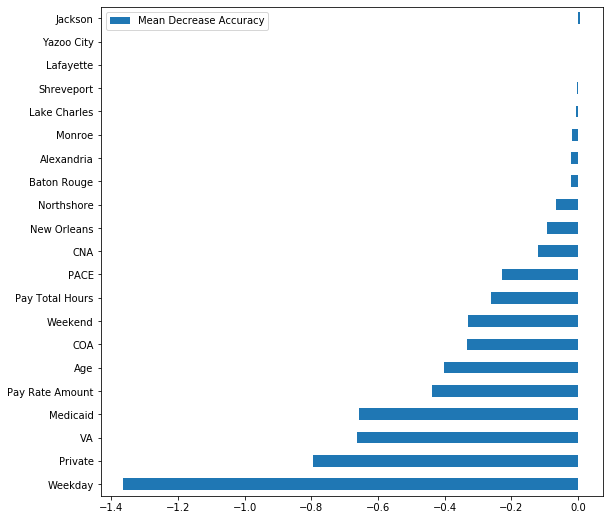

In [88]:
print('Gradient Boosting Shuffle Split')
feature_shuffle(gb2, X, y)

Random Forest Shuffle Split


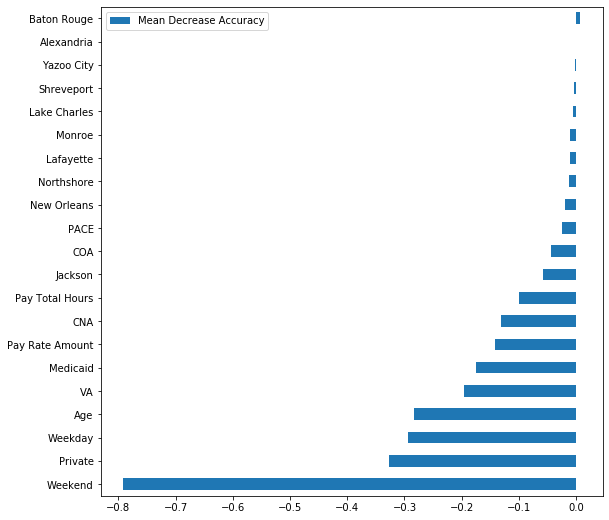

In [89]:
print('Random Forest Shuffle Split')
feature_shuffle(forest1, X, y)

Decision Tree Shuffle Split


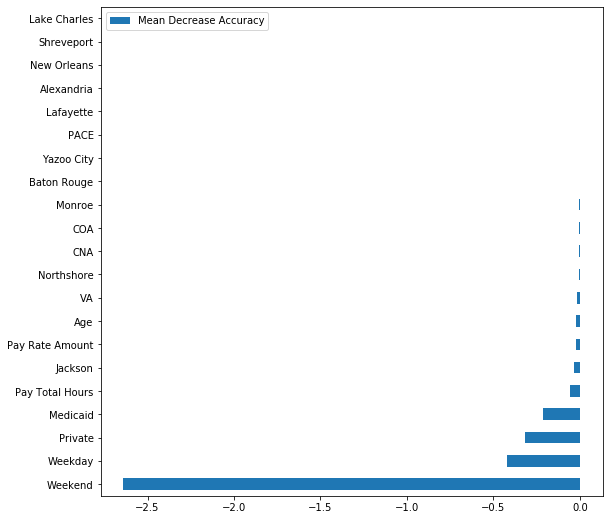

In [90]:
print('Decision Tree Shuffle Split')
feature_shuffle(dt1, X, y)

Gradient Boosting Feature Importance


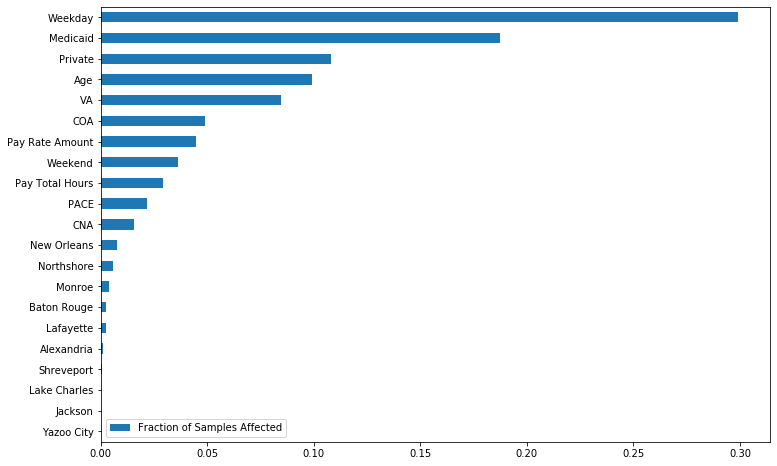

In [91]:
print('Gradient Boosting Feature Importance')
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : gb2.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize = (12,8))

Random Forest Feature Importance


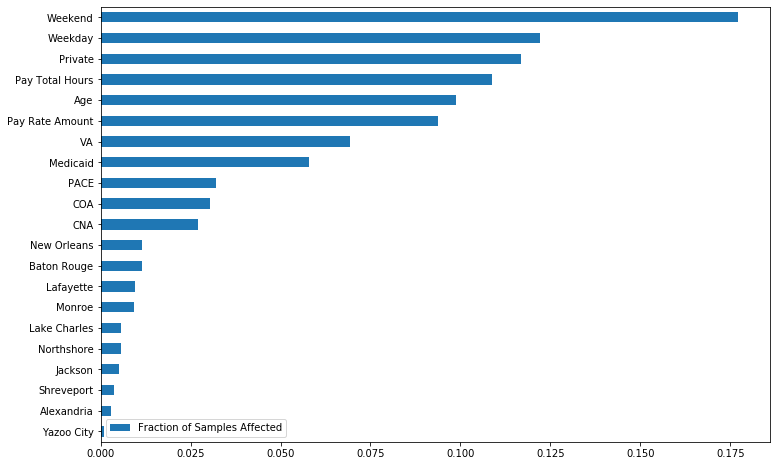

In [92]:
print('Random Forest Feature Importance')
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : forest1.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize = (12,8))

Decision Tree Feature Importance


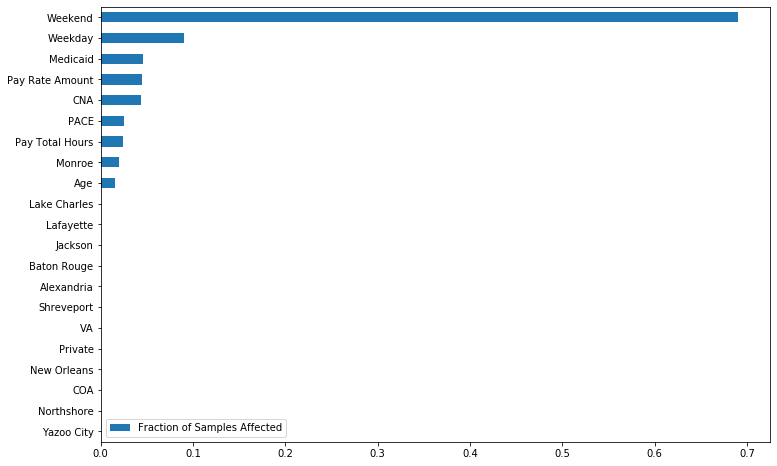

In [93]:
print('Decision Tree Feature Importance')
feat_scores = pd.DataFrame({'Fraction of Samples Affected' : dt1.feature_importances_},
                           index=X.columns)
feat_scores = feat_scores.sort_values(by='Fraction of Samples Affected')
feat_scores.plot(kind='barh', figsize = (12,8))

## Heatmap

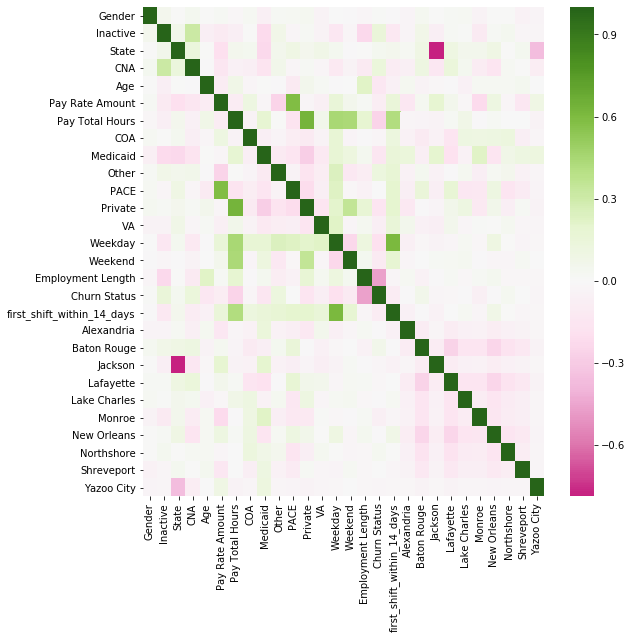

In [94]:
import seaborn as sns
def heatmap(df, fig_size):
    plt.figure(figsize=fig_size)
    sns.heatmap(df.corr(), cmap="PiYG", annot=False, center=0);

heatmap(caregivers, (9,9))

## ROC Curve

In [95]:
def calculate_threshold_values(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df
    
def plot_roc(ax, df):
    ax.plot([1]+list(df.fpr), [1]+list(df.tpr), label="ROC")
    ax.plot([0,1],[0,1], 'k', label="random")
    ax.set_xlabel('False Positive Rate', fontsize=15)
    ax.set_ylabel('True Positive Rate', fontsize=15)
    ax.set_title('ROC Curve', fontsize=20)
    ax.legend()
    

In [96]:
model = log_grid
model.fit(X_train, y_train)
df = calculate_threshold_values(model.predict_proba(X)[:,1], y)

model1 = dt1
model1.fit(X_train,y_train)
df1 = calculate_threshold_values(model1.predict_proba(X)[:,1], y)

model2 = forest1
model2.fit(X_train, y_train)
df2 = calculate_threshold_values(model2.predict_proba(X)[:,1], y)

model3 = gb1
model3.fit(X_train, y_train)
df3 = calculate_threshold_values(model3.predict_proba(X)[:,1], y)

model4 = knn1
model4.fit(X_train, y_train)
df4 = calculate_threshold_values(model4.predict_proba(X)[:,1], y)

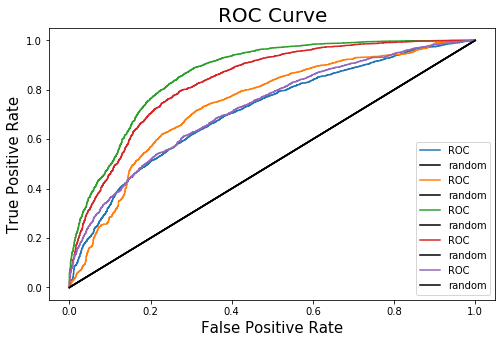

In [97]:
fig, ax = plt.subplots(figsize=(8,5))

plot_roc(ax, df)
plot_roc(ax, df1)
plot_roc(ax, df2)
plot_roc(ax, df3)
plot_roc(ax, df4)

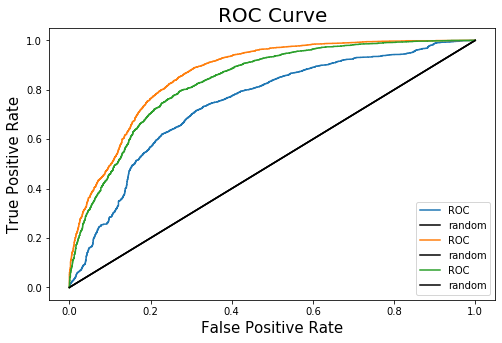

In [98]:
fig, ax = plt.subplots(figsize=(8,5))

plot_roc(ax, df1) #dt blue
plot_roc(ax, df2) #forest green
plot_roc(ax, df3) #gb yellow
ax.legend(loc='lower right');

## Confusion Matrix

In [99]:
from src.models import confusion

In [100]:
cm_dt = confusion_matrix(y_test, model1.predict(X_test))
cm_forest = confusion_matrix(y_test, model2.predict(X_test))
cm_gb = confusion_matrix(y_test, model3.predict(X_test))

In [101]:
# TP = cm[0][0]
# FP = cm[0][1]
# FN = cm[1][0]
# TN = cm[1][1]

# print('TP', TP)
# print('FP', FP)
# print('FN', FN)
# print('TN', TN)

Gradient Boosting Confusion Matrix


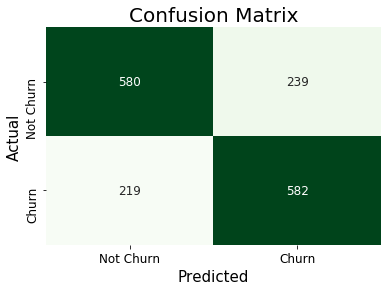

In [102]:
print('Gradient Boosting Confusion Matrix')
confusion(cm_gb)

Random Forest Confusion Matrix


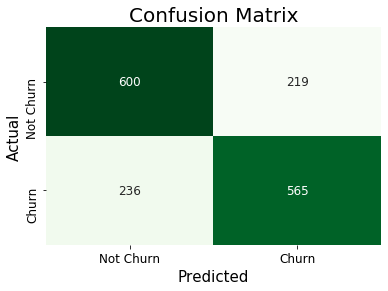

In [103]:
print('Random Forest Confusion Matrix')
confusion(cm_forest)

Decision Tree Confusion Matrix


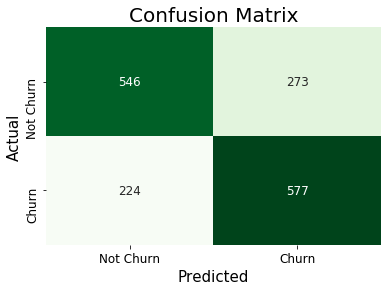

In [104]:
print('Decision Tree Confusion Matrix')
confusion(cm_dt)

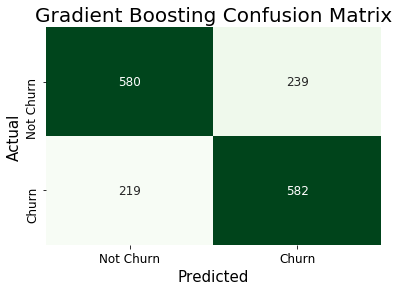

In [171]:
def confusion(cm):
    ax= plt.subplot()
    labels =  np.array([[633, 202],
           [293, 492]])
    sns.heatmap(cm, annot=True, ax = ax, fmt='g', cbar=False, annot_kws={"size": 12}, cmap='Greens'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted', fontsize=15);ax.set_ylabel('Actual', fontsize=15); 
    ax.set_title('Gradient Boosting Confusion Matrix', fontsize=20); 
    ax.yaxis.set_ticklabels(['Not Churn', 'Churn'], fontsize=12); ax.xaxis.set_ticklabels(['Not Churn', 'Churn'], fontsize=12);
    
confusion(cm_gb) 

## Graphs for Read Me

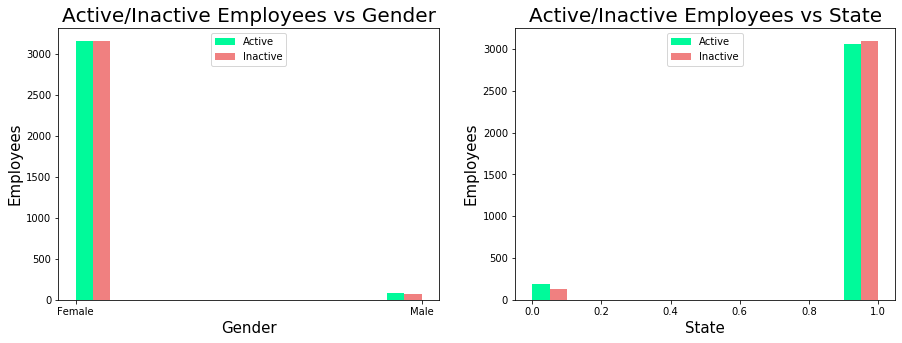

In [105]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
active2=active.copy()
active2['State'] = np.where(active2['State'] == 1, 'LA', 'MS')
active2['Gender'] = np.where(active2['Gender'] == 1, 'Female', 'Male')

inactive2=inactive.copy()
inactive2['Gender'] = np.where(inactive2['Gender'] == 1, 'Female', 'Male')
inactive2['State'] = np.where(inactive2['State'] == 1, 'LA', 'MS')

ax[0].hist([active2['Gender'], 
         inactive2['Gender']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax[0].legend(loc='upper center');
ax[0].set_xlabel('Gender',fontsize=15)
ax[0].set_ylabel('Employees', fontsize=15) 
ax[0].set_title('Active/Inactive Employees vs Gender', fontsize=20)

ax[1].hist([active['State'], 
         inactive['State']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax[1].legend(loc='upper center');
ax[1].set_xlabel('State',fontsize=15)
ax[1].set_ylabel('Employees', fontsize=15)
ax[1].set_title('Active/Inactive Employees vs State', fontsize=20);

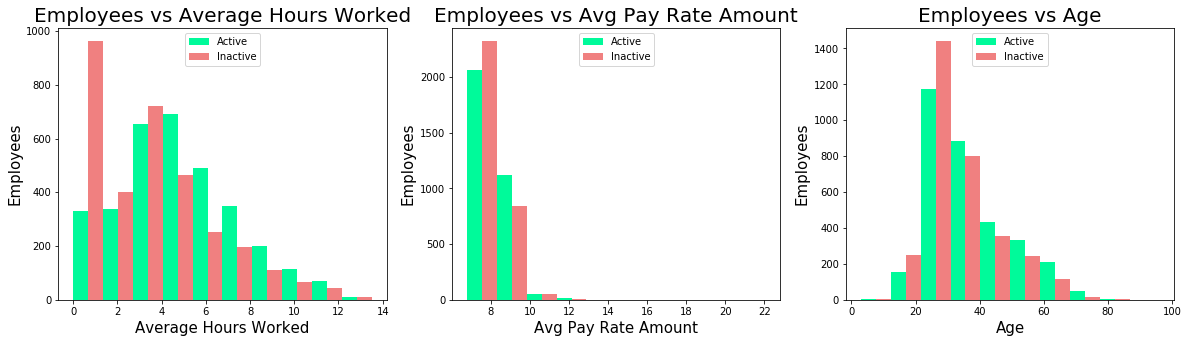

In [106]:
active = caregivers[caregivers['Employment Length'] >= np.median(caregivers['Employment Length'])]
inactive = caregivers[caregivers['Employment Length'] < np.median(caregivers['Employment Length'])]


fig, ax = plt.subplots(1,3,figsize=(20,5))


ax[0].hist([active2['Pay Total Hours'], 
         inactive2['Pay Total Hours']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax[0].legend(loc='upper center');
ax[0].set_xlabel('Average Hours Worked',fontsize=15)
ax[0].set_ylabel('Employees', fontsize=15) 
ax[0].set_title('Employees vs Average Hours Worked', fontsize=20)

ax[1].hist([active2['Pay Rate Amount'], 
         inactive2['Pay Rate Amount']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax[1].legend(loc='upper center');
ax[1].set_xlabel('Avg Pay Rate Amount',fontsize=15)
ax[1].set_ylabel('Employees', fontsize=15)
ax[1].set_title('Employees vs Avg Pay Rate Amount', fontsize=20)

ax[2].hist([active2['Age'], 
         inactive2['Age']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax[2].legend(loc='upper center');
ax[2].set_xlabel('Age',fontsize=15)
ax[2].set_ylabel('Employees', fontsize=15)
ax[2].set_title('Employees vs Age', fontsize=20);

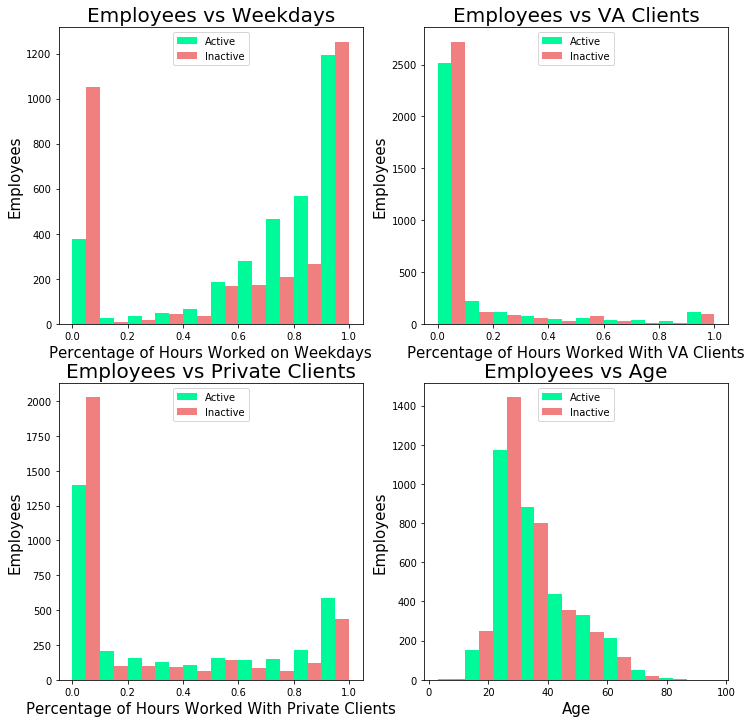

In [150]:
active = caregivers[caregivers['Employment Length'] >= np.median(caregivers['Employment Length'])]
inactive = caregivers[caregivers['Employment Length'] < np.median(caregivers['Employment Length'])]


fig, ax = plt.subplots(2,2,figsize=(12,12))


ax[0][0].hist([active2['Weekday'], 
         inactive2['Weekday']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax[0][0].legend(loc='upper center');
ax[0][0].set_xlabel('Percentage of Hours Worked on Weekdays',fontsize=15)
ax[0][0].set_ylabel('Employees', fontsize=15) 
ax[0][0].set_title('Employees vs Weekdays', fontsize=20)

ax[0][1].hist([active2['VA'], 
         inactive2['VA']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax[0][1].legend(loc='upper center');
ax[0][1].set_xlabel('Percentage of Hours Worked With VA Clients',fontsize=15)
ax[0][1].set_ylabel('Employees', fontsize=15)
ax[0][1].set_title('Employees vs VA Clients', fontsize=20)


ax[1][1].hist([active2['Age'], 
         inactive2['Age']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax[1][1].legend(loc='upper center');
ax[1][1].set_xlabel('Age',fontsize=15)
ax[1][1].set_ylabel('Employees', fontsize=15)
ax[1][1].set_title('Employees vs Age', fontsize=20)

ax[1][0].hist([active2['Private'], 
         inactive2['Private']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax[1][0].legend(loc='upper center');
ax[1][0].set_xlabel('Percentage of Hours Worked With Private Clients',fontsize=15)
ax[1][0].set_ylabel('Employees', fontsize=15)
ax[1][0].set_title('Employees vs Private Clients', fontsize=20);

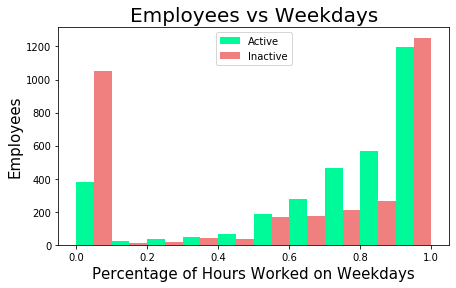

In [165]:
fig, ax = plt.subplots(figsize=(7,4))


ax.hist([active2['Weekday'], 
         inactive2['Weekday']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax.legend(loc='upper center');
ax.set_xlabel('Percentage of Hours Worked on Weekdays',fontsize=15)
ax.set_ylabel('Employees', fontsize=15) 
ax.set_title('Employees vs Weekdays', fontsize=20);

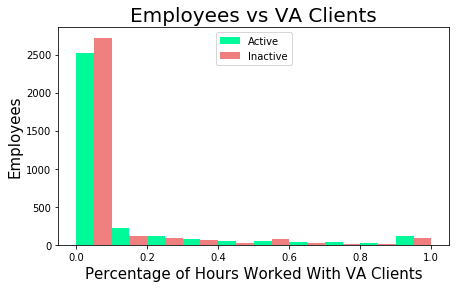

In [166]:
fig, ax = plt.subplots(figsize=(7,4))
ax.hist([active2['VA'], 
         inactive2['VA']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax.legend(loc='upper center');
ax.set_xlabel('Percentage of Hours Worked With VA Clients',fontsize=15)
ax.set_ylabel('Employees', fontsize=15)
ax.set_title('Employees vs VA Clients', fontsize=20);

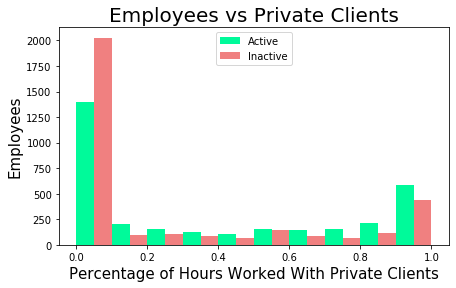

In [167]:
fig, ax = plt.subplots(figsize=(7,4))
ax.hist([active2['Private'], 
         inactive2['Private']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax.legend(loc='upper center');
ax.set_xlabel('Percentage of Hours Worked With Private Clients',fontsize=15)
ax.set_ylabel('Employees', fontsize=15)
ax.set_title('Employees vs Private Clients', fontsize=20);

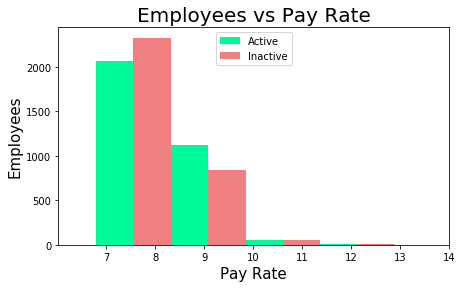

In [170]:
fig, ax = plt.subplots(figsize=(7,4))
ax.hist([active2['Pay Rate Amount'], 
         inactive2['Pay Rate Amount']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax.legend(loc='upper center');
ax.set_xlabel('Pay Rate',fontsize=15)
ax.set_ylabel('Employees', fontsize=15)
ax.set_xlim(right=14)
ax.set_title('Employees vs Pay Rate', fontsize=20);

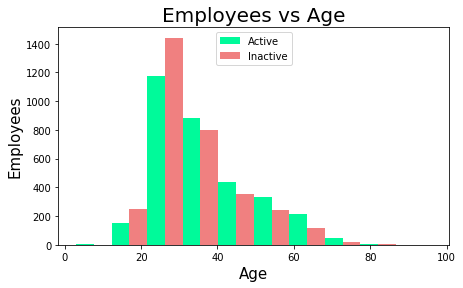

In [168]:
fig, ax = plt.subplots(figsize=(7,4))
ax.hist([active2['Age'], 
         inactive2['Age']], 
        label=['Active', 'Inactive'], 
       color = ['mediumspringgreen', 'lightcoral'], rwidth=100)
ax.legend(loc='upper center');
ax.set_xlabel('Age',fontsize=15)
ax.set_ylabel('Employees', fontsize=15)
ax.set_title('Employees vs Age', fontsize=20);

In [129]:
caregivers['Private'].max()

1.0

In [107]:
#Graph above looks very skewed, check amounts for each.
pay_info1 = pay_info.copy()
for i in range(0,30,5):
    x = pay_info1[pay_info1['Pay Rate Amount']<i].count()['Payroll ID']
    pay_info1 = pay_info1[pay_info1['Pay Rate Amount']>=i]
    print('by ${} {} employees left'.format(i, x))

by $0 0 employees left
by $5 28 employees left
by $10 459099 employees left
by $15 22979 employees left
by $20 317 employees left
by $25 127 employees left


In [108]:
pay_info1[pay_info1['Bill Rate Name'].isnull()]

,Payroll ID,Bill Rate Name,Pay Rate Amount,Pay Total Hours,Official Clock In Date,COA,Medicaid,Other,PACE,Private,VA,Weekday,Weekend


In [109]:
pay_info1['Pay Rate Amount'] = pay_info1.apply(lambda x: 8 if x['Bill Rate Name'] == 'Live-In' else x['Pay Rate Amount'], axis=1)
pay_info1.head()

,Payroll ID,Bill Rate Name,Pay Rate Amount,Pay Total Hours,Official Clock In Date,COA,Medicaid,Other,PACE,Private,VA,Weekday,Weekend
8780,116753.0,Private,25.0,6.25,2019-04-27,0,0,0,0,0,0,0,1


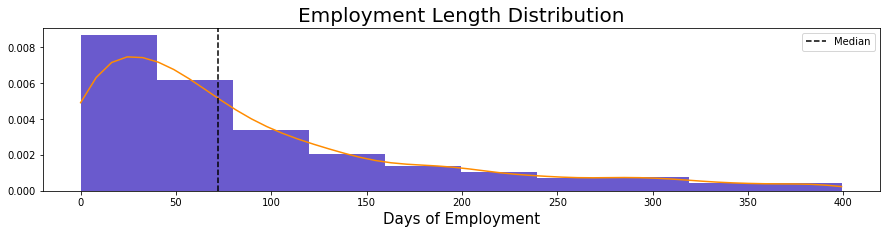

In [110]:
x_200 = caregivers[caregivers['Employment Length']<400]
x = np.linspace(np.min(x_200['Employment Length']), np.max(x_200['Employment Length']))
kde = gaussian_kde(x_200['Employment Length'])
fig, ax = plt.subplots(figsize=(15,3))
ax.hist(x_200['Employment Length'], density=True, color = 'slateblue')
ax.plot(x, kde(x), color='darkorange')
ax.set_title('Employment Length Distribution', fontsize=20)
ax.set_xlabel('Days of Employment', fontsize=15)
ax.axvline(round(caregivers['Employment Length'].median(),2), color='black',linestyle='--', label='Median')
ax.legend()


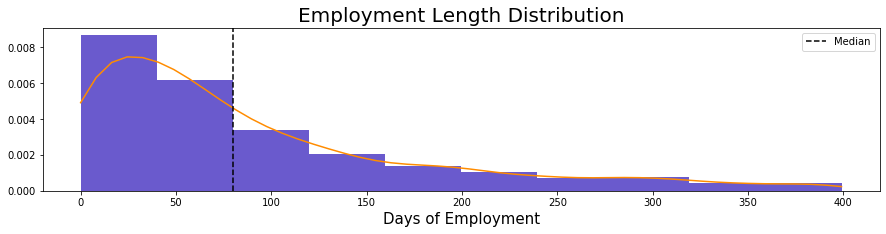

In [120]:
x_200 = caregivers[caregivers['Employment Length']<400]
x = np.linspace(np.min(x_200['Employment Length']), np.max(x_200['Employment Length']))
kde = gaussian_kde(x_200['Employment Length'])
fig, ax = plt.subplots(figsize=(15,3))
ax.hist(x_200['Employment Length'], density=True, color = 'slateblue')
ax.plot(x, kde(x), color='darkorange')
ax.set_title('Employment Length Distribution', fontsize=20)
ax.set_xlabel('Days of Employment', fontsize=15)
ax.axvline(80, color='black',linestyle='--', label='Median')
ax.legend()

In [111]:
caregivers10 = pd.concat([cgs, cgs2]).drop_duplicates(subset='Payroll ID')
caregivers10.shape

(7738, 11)

In [112]:
pay_info.shape

(482556, 13)

In [113]:
caregivers['Pay Rate Amount'].median()

8.0

In [121]:
8*.16

1.28

In [125]:
(8*52*30)*.16

1996.8

In [124]:
(10.50*52*30)*.16

2620.8